# Error Stats vs Different seq_len

In [1]:
with open("../result.txt", "r") as file:
  lines = file.readlines()
mse, mae, rse, tg = [], [], [], []
for line in lines:
  if 'tg' in line:
    # print(line)
    tg.append(line.split('tg')[1].split('_')[0])
  if 'mse' in line:
    mse.append(round(float(line.split('mse:')[1].split(',')[0]), 3))
  if 'mae' in line:
    mae.append(round(float(line.split('mae:')[1].split(',')[0]), 3))
  if 'rse' in line:
    rse.append(round(float(line.split('rse:')[1].split(',')[0]), 3))

In [2]:
import pandas as pd
import numpy as np

idx = ['96', '192', '336', '720']
cols = list(dict.fromkeys(tg))

def plot_model_perf(error_type: str, error_list: list[float], idx_list: list[str]):
  x = np.reshape(error_list, (int(len(error_list)/len(idx)), len(idx_list))).T
  df = pd.DataFrame(x, columns=cols, index=idx_list)
  print(df)
  df.plot(style='--', marker='o', mfc='none', xlabel='Sequence Length', ylabel=error_type).legend(loc='upper right')

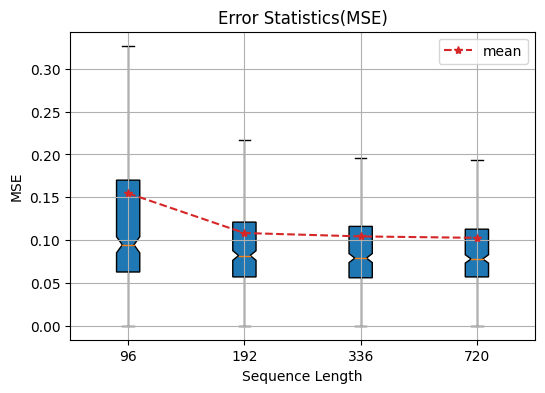

In [35]:
import matplotlib.pyplot as plt

def plot_box(error_type: str, error_list: list[float], idx_list: list[str]):
  x = np.reshape(error_list, (int(len(error_list)/len(idx_list)), len(idx_list)))
  x_mean = [np.mean(t) for t in x.T]

  fig, ax = plt.subplots(figsize=(6, 4))
  showfliers = False
  showmeans = False
  patch_artist = True
  positions = np.arange(1, len(idx_list)+1)
  width = 0.2
  widths = tuple([0.2] * len(idx_list))

  ax.boxplot(x, positions=positions, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
  ax.plot(positions, x_mean, '--', color='tab:red', marker='*', label='mean', zorder=2)
  ax.grid()
  ax.legend()
  ax.set_xticklabels(idx_list)
  ax.set_title("Error Statistics({})".format(error_type))
  ax.set_xlabel('Sequence Length')
  ax.set_ylabel(error_type)

plot_box('MSE', mse, idx)

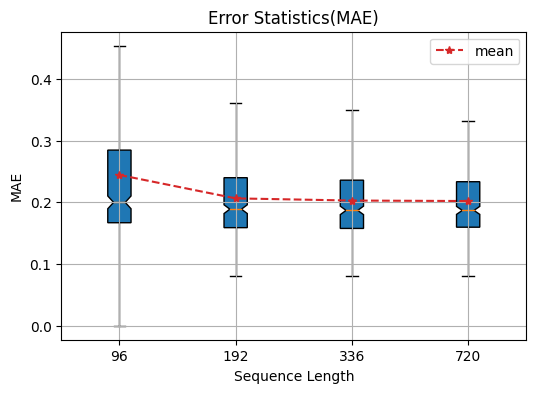

In [36]:
plot_box('MAE', mae, idx)

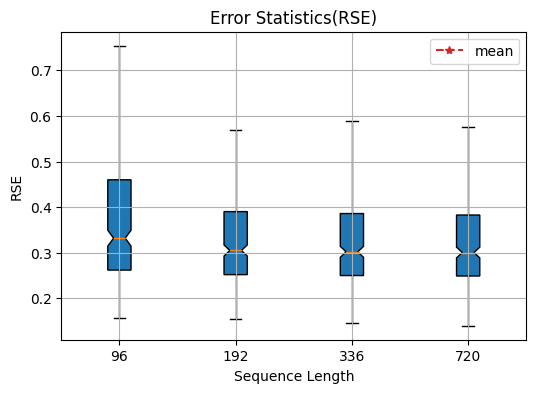

In [37]:
plot_box('RSE', rse, idx)

# Aggregate Models

Model(
  (Linear): Linear(in_features=720, out_features=24, bias=True)
) with 17304 parameters
tensor([[[4196.3628],
         [3836.9534],
         [3484.6255],
         [3171.6021],
         [2961.2351],
         [3080.6077],
         [2865.0957],
         [2750.0071],
         [2954.9578],
         [3556.8943],
         [4122.8159],
         [4962.8218],
         [5468.5239],
         [4938.0308],
         [4677.5400],
         [4344.7642],
         [4394.7690],
         [4906.1250],
         [5874.3003],
         [6647.4531],
         [6370.3950],
         [6120.6641],
         [5637.2134],
         [4994.0132]]], grad_fn=<PermuteBackward0>)


/mnt/zkpet/venv/lib/python3.10/site-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


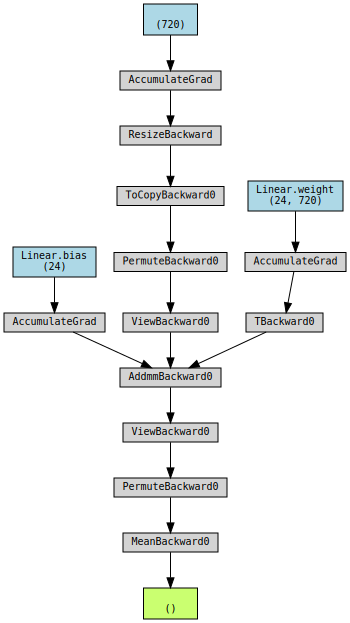

In [1]:
import torch
from torchviz import make_dot
import pandas as pd
import sys
sys.path.append("..")
from models.DLinear import Model as DLinear
from models.Linear import Model as Linear
from models.NLinear import Model as NLinear


class Configs:
    def __init__(self, seq_len, pred_len):
      self.seq_len = seq_len
      self.pred_len = pred_len
      self.enc_in = 321
      self.individual = False

model = 'Linear'
target = '40'
seq_len = 192
pred_len = 24

configs = Configs(seq_len, pred_len)
match model:
  case 'Linear':
    circuit = Linear(configs)
  case 'DLinear':
    circuit = DLinear(configs)
  case 'NLinear':
    circuit = NLinear(configs)

basepath = '../checkpoints/Electricity_{}_{}_{}_custom_ftS_tg{}_sl{}_ll48_pl{}_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth'
check_point_model = basepath.format(seq_len, pred_len, model, target, seq_len, pred_len)

state_dict = torch.load(check_point_model)
circuit.load_state_dict(state_dict)

total_params = sum(
	param.numel() for param in circuit.parameters()
)

print(circuit, 'with {} parameters'.format(total_params))

df = pd.read_csv('../dataset/electricity.csv')
# Load the last seq_len entries data as input and converts to tensor
# x = 10*torch.rand(1,*[seq_len, 1], requires_grad=True)
x = torch.tensor(df[target][-seq_len:].values, requires_grad=True).resize(1, seq_len, 1).float()
# Flips the neural net into inference mode
circuit.eval()

y = circuit(x)
print(y)

# Visualize the trained model
# make_dot(y.mean(), params=dict(circuit.named_parameters()), show_attrs=True, show_saved=True)
make_dot(y.mean(), params=dict(circuit.named_parameters()))
# img = make_dot(y.mean(), params=dict(circuit.named_parameters()))
# img.render(model, format="png")

In [73]:
import torch
from torchviz import make_dot
import pandas as pd
import sys
sys.path.append("..")
from models.DLinear import Model as DLinear
from models.Linear import Model as Linear
from models.NLinear import Model as NLinear
import warnings
warnings.filterwarnings("ignore")

class Configs:
    def __init__(self, seq_len, pred_len):
      self.seq_len = seq_len
      self.pred_len = pred_len
      self.enc_in = 321
      self.individual = False

model = 'Linear'
target = '40'
seq_len = 192
pred_len = 24

configs = Configs(seq_len, pred_len)
match model:
  case 'Linear':
    circuit = Linear(configs)
  case 'DLinear':
    circuit = DLinear(configs)
  case 'NLinear':
    circuit = NLinear(configs)
    
basepath = '../checkpoints/Electricity_{}_{}_{}_custom_ftS_tg{}_sl{}_ll48_pl{}_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth'
df = pd.read_csv('../dataset/electricity.csv')
df_pred = df[['date']][-pred_len:]

for target in range(320):
    check_point_model = basepath.format(seq_len, pred_len, model, target, seq_len, pred_len)
    state_dict = torch.load(check_point_model)
    circuit.load_state_dict(state_dict)
    # Load the last seq_len entries data as input and converts to tensor
    x = torch.tensor(df[str(target)][-(seq_len+pred_len):-pred_len].values, requires_grad=True).resize(1, seq_len, 1).float()
    # Flips the neural net into inference mode
    circuit.eval()
    y = circuit(x)
    # print("Processing # {}".format(target))
    df_pred[str(target)] = (y.detach().cpu().numpy()[0].flatten())

df_pred['Agg_Prediction'] = df_pred.iloc[:, 1:].sum(axis=1)
df_aggr = df[-pred_len:].set_index('date')
df_aggr['Agg_GroundTruth'] = df_aggr.iloc[:, 1:-1].sum(axis=1)

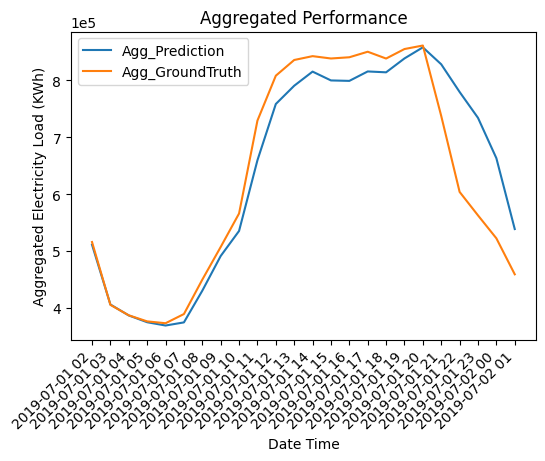

In [94]:
import numpy as np
import matplotlib.pyplot as plt

x_data = [dt.split(':')[0] for dt in df_aggr.index.values]
y_pred = df_pred['Agg_Prediction'].values
y_truth = df_aggr['Agg_GroundTruth'].values

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x_data, y_pred, label='Agg_Prediction')
ax.plot(x_data, y_truth, label='Agg_GroundTruth')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set(xlabel='Date Time', ylabel='Aggregated Electricity Load (KWh)', title='Aggregated Performance')
ax.legend()
plt.xticks(rotation=45, ha='right')

plt.show()

In [93]:
# Mean Squared Error 
MSE = np.square(np.subtract(y_truth,y_pred)).mean()
MSE

4648628213.144368